# Table of contents
1. [Libraries](#libraries)
2. [Question](#quesion)
3. [Data Preparation](#preparation)
4. [Modelling](#modelling)
5. [Evaluation](#evaluation)

<h1 id ="libraries">1. Libraries </h1>

In [357]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

<h1 id = "question">2. Question </h1>

**A question:** Predict the gross of movies

**Answering this question will help us:**

<h1 id = 'preparation'>3. Data Preparation </h1>

In [358]:
data = pd.read_csv('/content/preprocessed_data.csv')

In [359]:
data['Total Gross'] = data['Worldwide Gross'] + data['Domestic Gross']

- Check for skewness

In [360]:
# Check the skewness of production budget and worldwide/domestic gross
print('Production Budget: ',data['Production Budget'].skew())
print('Worldwide Gross: ', data['Worldwide Gross'].skew())
print('Domestic Gross: ', data['Domestic Gross'].skew())
print('Total Gross: ', data['Total Gross'].skew())

Production Budget:  2.716733700616222
Worldwide Gross:  4.833655536153712
Domestic Gross:  3.845856866276893
Total Gross:  4.528670983843642


As can be seen, the skewness in 3 economic features is heavily positively skewed, therefore we need to **log transform** these features.

However, before log transform we will need to multiply the inflation rate of each year to have the accurate calculation and analysis

- Multiply the inflation rate

In [361]:
inflation_data = pd.read_csv('/content/inflation_rate.csv')
def get_unit(year):
    if year in inflation_data['Year'].values:
        return float(inflation_data[inflation_data['Year'] == year]['Unit'].iloc[0])
    else:
        return 1

data['Year'] = pd.to_datetime(data['Release Date']).dt.year
data['Month'] = pd.to_datetime(data['Release Date']).dt.month
data['Unit'] = data['Year'].apply(get_unit)

# Adjust the economic columns by dividing them by the 'Unit' (inflation adjustment factor)
economic_features = ['Production Budget', 'Domestic Gross', 'Worldwide Gross', 'Total Gross']

for feature in economic_features:
    data[feature] = data[feature] * (data['Unit'] / data['Unit'].iloc[-1])

- Apply log transformation

In [362]:
data['Production Budget'] = (data['Production Budget'] + 1).apply(np.log)
data['Worldwide Gross'] = (data['Worldwide Gross'] + 1).apply(np.log)
data['Domestic Gross'] = (data['Domestic Gross'] + 1).apply(np.log)
data['Total Gross'] = (data['Total Gross'] + 1).apply(np.log)

In [363]:
# Check the skewness of production budget and worldwide/domestic gross
print('Production Budget: ',data['Production Budget'].skew())
print('Worldwide Gross: ', data['Worldwide Gross'].skew())
print('Domestic Gross: ', data['Domestic Gross'].skew())
print('Total Gross: ', data['Total Gross'].skew())

Production Budget:  -1.2385073021159054
Worldwide Gross:  -2.309653698508934
Domestic Gross:  -1.9215609957312432
Total Gross:  -2.3645574880844813


After the transformation, the features now exhibit negative skewness, which is still acceptable for many regression models.

- **`Cast and Director`**
    - As the domain information collected, the cost of these features are already included in **`Production Budget`**, therefore, we can remove these columns out of our current data

In [364]:
# data = data.drop(columns=['Cast', 'Director'])


- Check the distribution of Total Gross

Text(0, 0.5, 'Frequency')

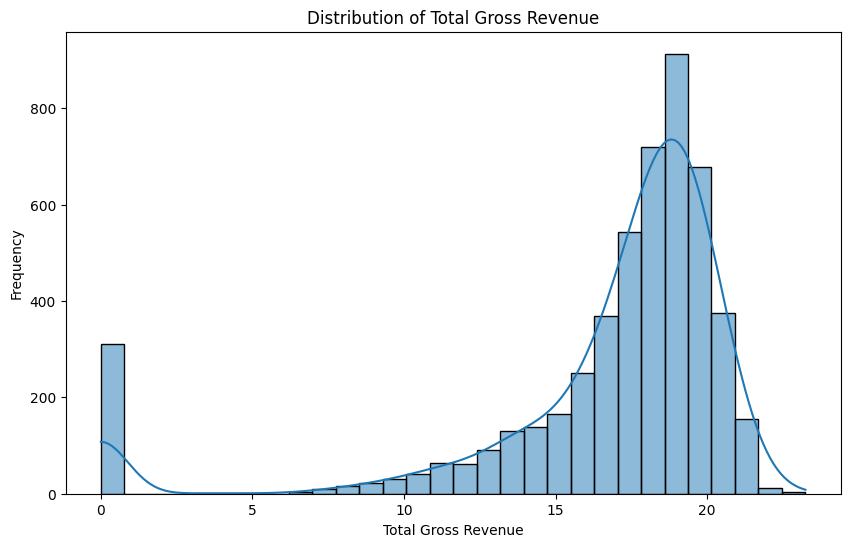

In [365]:
# Plot the distribution of total gross revenue
plt.figure(figsize=(10, 6))
sns.histplot(data['Total Gross'], bins=30, kde=True)
plt.title('Distribution of Total Gross Revenue')
plt.xlabel('Total Gross Revenue')
plt.ylabel('Frequency')

Unexpectedly, there are a huge number of films that have revenue is 0, this can be because, some of films' revenues were not recorded. Therefore, we decided to delete movies having revenue equals to 0

In [366]:
data = data[data['Total Gross'] > 0]

data = data.reset_index(drop=True)

In [367]:
numerical_features = ['Tomatoes CriticScore', 'Tomatoes UserScore',
                      'Production Budget', 'Metascore', 'Meta UserScore', 'Month', 'Year']
categorical_features = ['Genre', 'Rating', 'Studio', 'Cast', 'Director']


X = data[numerical_features+categorical_features].copy()
y = data['Total Gross'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Feature selection for numerical columns

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


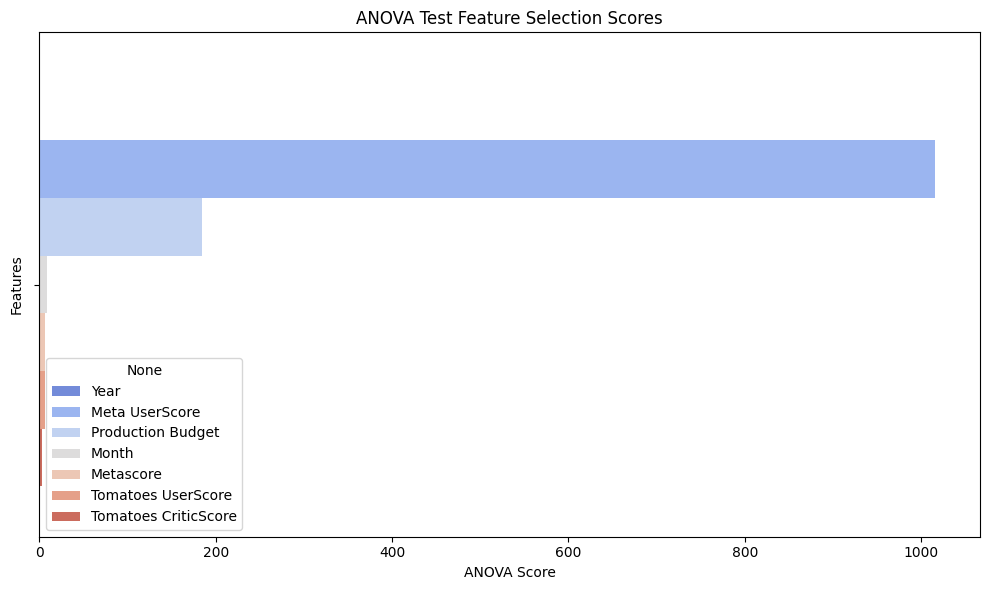

In [368]:
from sklearn.feature_selection import f_classif

X_numerical = X_train[numerical_features]  # Use column names directly

# Fit SelectKBest with chi2
selector = SelectKBest(f_classif, k=5)
selector.fit(X_numerical, y_train)

# Get Chi2 scores
scores = pd.DataFrame(data=selector.scores_, index=numerical_features, columns=['score'])
scores = scores.sort_values(by='score', ascending=False)

# Barplot for better visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=scores['score'], hue=scores.index, palette='coolwarm')
plt.title('ANOVA Test Feature Selection Scores')
plt.xlabel('ANOVA Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [369]:
# Ensure no missing values in `y`
X = X.reset_index(drop=True)  # Reset index to match
y = y.reset_index(drop=True)  # Reset index to match

# Drop rows with NaN in either X or y
X, y = X.align(y, join='inner', axis=0)


In [370]:
data = data.dropna(subset=['Total Gross'])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

def reformat_genre(genre_string):
    genre_string = genre_string.replace('[','').replace(']','').replace('"','')
    genre_list = [genre.strip().strip("'") for genre in genre_string.split(',')]
    return genre_list

X['Genre'] = X['Genre'].apply(reformat_genre)

#Get unique
unique_genres = set(genre for sublist in X['Genre'] for genre in sublist)

#One hot encoding Genre
for genre in unique_genres:
    X[f'Genre_{genre}'] = X['Genre'].apply(lambda x: 1 if genre in x else 0)

X = X.drop(columns=['Genre'])

#One hot encoding Rating
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(X[['Rating']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Rating']))

X = pd.concat([X, encoded_df], axis=1).drop(['Rating'], axis=1)

n_studio = 50 # One hot encoding for top 50 studio with most movies

if 'Studio' in X.columns:

  n_tops = n_studio

  top_studios = X['Studio'].value_counts().nlargest(n_tops)
  X['Studio'] = X['Studio'].apply(lambda x: x if x in top_studios else 'Studio Other')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Studio']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Studio']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Studio'], axis=1)



- Feature selection for categorical columns

<ipython-input-371-1caf67043ed5>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=scores.head(5).index, x=scores.head(5)['score'], palette='coolwarm')


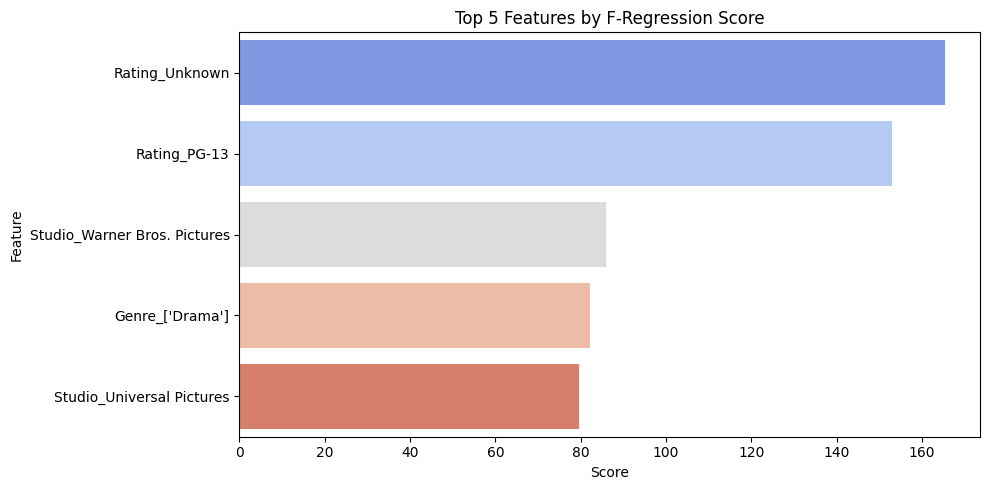

In [371]:
# One-hot encode categorical features

X_categorical = X_train[categorical_features]  # Use column names directly
X_categorical = X_categorical.fillna(0)

X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

# Fit SelectKBest with f_regression
selector = SelectKBest(f_regression, k=5)
selector.fit(X_categorical_encoded, y_train)

# Get scores
scores = pd.DataFrame(data=selector.scores_,
                      index=X_categorical_encoded.columns,
                      columns=['score'])
scores = scores.sort_values(by='score', ascending=False)

# Get the top 5 features
top_5_categorical = scores.head(5).index.tolist()

# Plot the top 5 scores
plt.figure(figsize=(10, 5))
sns.barplot(y=scores.head(5).index, x=scores.head(5)['score'], palette='coolwarm')
plt.title('Top 5 Features by F-Regression Score')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


As can be seen from the plot, some members of **`Genre`** and **`Rating`** shows up in top 5 F-Regression Score, therefore we will need to include these columns for modelling

In [372]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
        ])

feature_selector = SelectKBest(score_func=f_regression, k=7)


- XGBoost

In [373]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,
                   random_state=42, objective='reg:squarederror')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('model', xgb)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 8. Đánh giá kết quả
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

MAE: 1.2064204778508953
MSE: 3.006304373429371
R2: 0.541534793312336


- XGBoost with GridSearchCV

In [374]:
# from sklearn.model_selection import GridSearchCV, cross_val_score

# param_grid = {
#     'model__n_estimators': [50, 100, 200],         # Số lượng cây
#     'model__max_depth': [3, 6, 9],                 # Độ sâu tối đa của cây
#     'model__learning_rate': [0.01, 0.1, 0.2],     # Tốc độ học
#     'model__subsample': [0.8, 1.0],                # Tỷ lệ mẫu
#     'model__colsample_bytree': [0.8, 1.0]          # Tỷ lệ cột
# }

# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# grid_search.fit(X_train, y_train)
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = best_model.score(X_test, y_test)
# mae = mean_absolute_error(y_test, y_pred)
# print(f'MAE: {mae}')
# print(f'MSE: {mse}')
# print(f'R2: {r2}')

- Gradient Boosting Regressor

In [375]:
from sklearn.ensemble import GradientBoostingRegressor

gbg = GradientBoostingRegressor(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('model', gbg)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 8. Đánh giá kết quả
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

MAE: 1.206426775045822
MSE: 3.031765297528064
R2: 0.5376519702913088


- Gradient Boosting Regressor with GridSearchCV

In [376]:
# from sklearn.model_selection import GridSearchCV, cross_val_score

# param_grid = {
#     'model__n_estimators': [50, 100, 200],          # Số lượng cây trong mô hình
#     'model__max_depth': [3, 5, 7],                  # Độ sâu của mỗi cây
#     'model__learning_rate': [0.01, 0.05, 0.1],      # Tốc độ học
#     'model__subsample': [0.8, 1.0],                 # Tỷ lệ mẫu
# }

# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# grid_search.fit(X_train, y_train)
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = best_model.score(X_test, y_test)
# print(f'Mean Squared Error: {mse}')
# print(f'R²: {r2}')

ML Model with Director and Cast and Studio added

Let's try with Director and Cast and Studio added, will the score improve

In [377]:
n_director = 10 # One hot encoding for top 10 director with most movies
n_cast = 20 # One hot encoding for top 20 cast with most movies
n_studio = 50 # One hot encoding for top 50 studio with most movies

In [378]:

numerical_features = ['Tomatoes CriticScore', 'Tomatoes UserScore',
                      'Production Budget', 'Metascore', 'Meta UserScore']

categorical_features = ['Year', 'Rating', 'Studio', 'Genre', 'Cast', 'Director']


X = data[numerical_features+categorical_features].copy()

y = data['Total Gross'].copy()





One Hot Encoding Director

In [379]:
if 'Director' in X.columns:

  n_top = n_director

  top_directors = X['Director'].value_counts().nlargest(n_top)
  X['Director'] = X['Director'].apply(lambda x: x if x in top_directors else 'Director Other')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Director']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Director']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Director'], axis=1)



One Hot Encoding Year

In [380]:
def bin_years(data, column, bins=10):

    min_year = data[column].min()
    max_year = data[column].max()
    bin_edges = np.linspace(min_year, max_year, bins + 1)
    bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1]) - 1}" for i in range(len(bin_edges) - 1)]
    binned_years = pd.cut(data[column], bins=bin_edges, labels=bin_labels, include_lowest=True)
    return binned_years

if 'Year' in X.columns:

  #Year are binned into 10 bins, each bins about 10 years
  n_bins = 10

  #Perform one hot encoding
  X['Year'] = bin_years(X, 'Year', bins = n_bins)
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Year']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Year']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Year'], axis=1)


One Hot Encoding Cast

In [381]:
#Reformat cast string into list
def reformat_cast(cast_string):
    if pd.isna(cast_string):
        return []
    cast_string = cast_string.replace('[','').replace(']','').replace('"','')
    cast_list = [cast.strip().strip("'") for cast in cast_string.split(',')]
    return cast_list

if 'Cast' in X.columns:

  n_top = n_cast  #Perform one hot for n_cast with most movies

  X['Cast'] = X['Cast'].apply(reformat_cast)
  top_cast = X['Cast'].explode().value_counts().nlargest(n_top)
  for cast in top_cast.index:
      X[f'Cast_{cast}'] = X['Cast'].apply(lambda x: 1 if cast in x else 0)
  X = X.drop(columns=['Cast'])

One Hot Encoding Genre

In [382]:
#One Hot Encoding Genre
def reformat_genre(genre_string):
    genre_string = genre_string.replace('[','').replace(']','').replace('"','')
    genre_list = [genre.strip().strip("'") for genre in genre_string.split(',')]
    return genre_list

if 'Genre' in X.columns:
  X['Genre'] = X['Genre'].apply(reformat_genre)
  #Get unique
  unique_genres = set(genre for sublist in X['Genre'] for genre in sublist)
  #One hot encoding Genre
  for genre in unique_genres:
      X[f'Genre_{genre}'] = X['Genre'].apply(lambda x: 1 if genre in x else 0)
  X = X.drop(columns=['Genre'])


One Hot Encoding Rating

In [383]:
#One hot encoding Rating
if 'Rating' in X.columns:
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Rating']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Rating']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Rating'], axis=1)

One Hot Encoding Studio


In [384]:
#One hot encoding Studio
if 'Studio' in X.columns:

  n_tops = n_studio

  top_studios = X['Studio'].value_counts().nlargest(n_tops)
  X['Studio'] = X['Studio'].apply(lambda x: x if x in top_studios else 'Studio Other')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Studio']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Studio']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Studio'], axis=1)


In [385]:
X

,Tomatoes CriticScore,Tomatoes UserScore,Production Budget,Metascore,Meta UserScore,Director_Director Other,Director_['Clint Eastwood'],Director_['Martin Scorsese'],Director_['Michael Curtiz'],Director_['Ridley Scott'],...,Studio_TriStar Pictures,Studio_United Artists,Studio_Universal Pictures,Studio_Unknown,Studio_Walt Disney,Studio_Walt Disney Pictures,Studio_Warner Bros.,Studio_Warner Bros. Pictures,Studio_Warner Home Vídeo,Studio_Weinstein Co.
0,99.0,94.0,17.980850,91.00,86.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,97.0,98.0,17.702056,100.00,93.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,99.0,95.0,16.686983,100.00,87.00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,99.0,90.0,16.428409,97.00,89.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,96.0,99.0,18.951309,78.00,84.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,13.0,52.0,12.846138,22.00,55.85,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4792,87.0,81.0,12.429220,59.00,64.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4793,91.0,68.0,14.654045,60.55,68.75,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4794,57.0,50.0,12.146250,62.00,67.40,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Standard Scaling

In [386]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
columns_to_scale = numerical_features

X[columns_to_scale] = scaler_X.fit_transform(X[columns_to_scale])
y = scaler_y.fit_transform(y.values.reshape(-1, 1))

y = y.flatten()
X = X.values


Train Test Split

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

XGBoots

In [388]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, objective='reg:squarederror')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Perform k-fold cross-validation with R² scoring
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Print individual fold scores and average R² score
print("Individual Fold R² Scores:", cv_scores)
print("Mean R² Score:", np.mean(cv_scores))
print("Standard Deviation of R² Score:", np.std(cv_scores))

Individual Fold R² Scores: [0.62554788 0.61809597 0.58748999 0.5892082  0.61252865]
Mean R² Score: 0.6065741379020683
Standard Deviation of R² Score: 0.01545310566814579


KNN

In [389]:
model = KNeighborsRegressor(n_neighbors=20)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Perform k-fold cross-validation with R² scoring
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Print individual fold scores and average R² score
print("Individual Fold R² Scores:", cv_scores)
print("Mean R² Score:", np.mean(cv_scores))
print("Standard Deviation of R² Score:", np.std(cv_scores))

Individual Fold R² Scores: [0.57136125 0.60157361 0.57793571 0.55061497 0.53665034]
Mean R² Score: 0.5676271759513233
Standard Deviation of R² Score: 0.02245684275876875


Decision Tree

In [390]:
model = DecisionTreeRegressor(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Perform k-fold cross-validation with R² scoring
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Print individual fold scores and average R² score
print("Individual Fold R² Scores:", cv_scores)
print("Mean R² Score:", np.mean(cv_scores))
print("Standard Deviation of R² Score:", np.std(cv_scores))

Individual Fold R² Scores: [0.1702308  0.25536195 0.28126695 0.26350135 0.13030971]
Mean R² Score: 0.22013415198246694
Standard Deviation of R² Score: 0.05902153179557012


Random Forest

In [391]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Perform k-fold cross-validation with R² scoring
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Print individual fold scores and average R² score
print("Individual Fold R² Scores:", cv_scores)
print("Mean R² Score:", np.mean(cv_scores))
print("Standard Deviation of R² Score:", np.std(cv_scores))

Individual Fold R² Scores: [0.60229957 0.5957133  0.58929816 0.57089896 0.56866733]
Mean R² Score: 0.5853754637348194
Standard Deviation of R² Score: 0.013397124440563407


Neural Network

In [392]:
import torch
from torch import nn

Convert Numpy Array To Tensor

In [393]:
X_train = torch.from_numpy(X_train).type(torch.float32)
X_test = torch.from_numpy(X_test).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32).squeeze()
y_test = torch.from_numpy(y_test).type(torch.float32)

Setup Device Agnostic Code

In [394]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Define Model

In [395]:
class Regression_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Sequential(
        nn.Linear(in_features = 133, out_features = 128),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features = 64),
        nn.ReLU(),
        nn.Linear(in_features = 64, out_features = 32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 16),
        nn.ReLU(),

    )
    self.layer_2 = nn.Sequential(
        nn.Linear(in_features = 16, out_features = 1),

    )
  def forward(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    return x

Loss Function And Optimizer

In [396]:
model = Regression_NN().to(device)
loss_function = nn.SmoothL1Loss()

optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01, momentum = 0.9)


Train Model

In [397]:
torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model.train()
  y_pred = model(X_train).squeeze()

  loss = loss_function(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()

  with torch.inference_mode():
    test_pred = model(X_test).squeeze()
    test_loss = loss_function(test_pred, y_test)
    test_accuracy = r2_score(y_test.cpu().numpy(), test_pred.cpu().numpy())
  if epoch == 0 or (epoch + 1)  % 100 == 0:
    print(f"Epoch: {epoch + 1}, Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Test Accuracy (R2): {test_accuracy:.4f}")


Epoch: 1, Loss: 0.3765, Test Loss: 0.3867, Test Accuracy (R2): -0.0082
Epoch: 100, Loss: 0.3718, Test Loss: 0.3805, Test Accuracy (R2): -0.0026
Epoch: 200, Loss: 0.3324, Test Loss: 0.3379, Test Accuracy (R2): 0.1173
Epoch: 300, Loss: 0.1797, Test Loss: 0.1901, Test Accuracy (R2): 0.5636
Epoch: 400, Loss: 0.1683, Test Loss: 0.1806, Test Accuracy (R2): 0.5904
Epoch: 500, Loss: 0.1615, Test Loss: 0.1748, Test Accuracy (R2): 0.6049
Epoch: 600, Loss: 0.1555, Test Loss: 0.1701, Test Accuracy (R2): 0.6170
Epoch: 700, Loss: 0.1495, Test Loss: 0.1662, Test Accuracy (R2): 0.6270
Epoch: 800, Loss: 0.1434, Test Loss: 0.1626, Test Accuracy (R2): 0.6361
Epoch: 900, Loss: 0.1371, Test Loss: 0.1599, Test Accuracy (R2): 0.6431
Epoch: 1000, Loss: 0.1306, Test Loss: 0.1584, Test Accuracy (R2): 0.6474


Evaluation

In [398]:
with torch.inference_mode():
    y_pred = model(X_test).squeeze()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Neural Network Report")
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)


Neural Network Report
MAE: 0.4181346
MSE: 0.3650739
R2: 0.647369833017033
